This skeleton code will get you started with the assignment.

For this assignment you will need at least:

- Pytorch 1.13+
- Sklearn
- Matplotlib

In [4]:
#importing all necessary libraries/modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torchinfo import summary

import torch.nn as nn
import torch.utils.data as data_utils
from torch import optim
from torchaudio import transforms

In [5]:
#initialize device, checking whether GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


### Data Loading
The data consists of waveforms of audioclips sampled 8000 times per second (8 khz).
The data is stored in 16 bit precision to reduce storage size. We first need to
convert the waveforms to 32 bit precision.

In [6]:
# create a variable containing the sampling rate of the data 
sampling_rate = 8_000

# create a list with data class labels, and a dictionary which couples each language with an index
languages = ["de", "en", "es", "fr", "nl", "pt"]
language_dict = {languages[i]: i for i in range(len(languages))}

# load the data from .npy files into variables, convert X data to float32 format
def load_langs():
    X_train, y_train = np.load("dataset/inputs_train_fp16.npy"), np.load(
        "dataset/targets_train_int8.npy"
    )
    X_test, y_test = np.load("dataset/inputs_test_fp16.npy"), np.load(
        "dataset/targets_test_int8.npy"
    )

    X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = load_langs()

# create input data tensors
tensor_X_train = torch.from_numpy(X_train)
tensor_X_test = torch.from_numpy(X_test)

# create target data tensors
tensor_y_train = torch.from_numpy(y_train)
tensor_y_test = torch.from_numpy(y_test)

# apply one-hot encoding and convert data to correct device
training = tensor_X_train
target_train = tensor_y_train.to(device)
target_train_ohe = nn.functional.one_hot(target_train.long(), 6).float()

test = tensor_X_test
target_test = tensor_y_test.to(device)
target_test_ohe = nn.functional.one_hot(target_test.long(), 6).float()

# set batch size
BATCH_SIZE = 200

# create Dataset variables and DataLoader variables
train_dataset = data_utils.TensorDataset(training, target_train_ohe) # unsqueeze so it gets shape (64, 1, 40, 201)
train_loader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) 

test_dataset = data_utils.TensorDataset(test, target_test_ohe)
test_loader = data_utils.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Data pre-processing

It is important that data preprocessing takes place in the model itself,
as only the model will be uploaded to the competition server.

So, rather than the usual, we will perform normalization and other preprocessing
steps as layers of the network. To help you with this, we provide an example of
a bogus normalization below.


Here, we multiply the input by a constant and subtract the max of each sample.
Follow this format to create your own normalization layer(s).

In [8]:
# create MFCC preprocessing layer
class MFCC_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.sample_rate = 40000/5
        self.transform_MFCC = transforms.MFCC(sample_rate = self.sample_rate)

    def forward(self, x):
        with torch.no_grad():
            x = x.unsqueeze(1)
            x = self.transform_MFCC(x)
        return x


### CNN model multi-class

In [9]:
# initialize MFCC layer   
MFCC_transformation = MFCC_layer()

# initialize model with MFCC layer
model = nn.Sequential(MFCC_transformation)

# add 2D Convolution, ReLU, BatchNorm and MaxPooling modules
# Layer 1
model.add_module('Conv_1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1))
model.add_module('Relu_1', nn.ReLU())
model.add_module('BatchNorm_1', nn.BatchNorm2d(num_features=32))

model.add_module('MaxPool_1', nn.MaxPool2d(kernel_size=2, padding=1))

# Layer 2
model.add_module('Conv_2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1))
model.add_module('Relu_2', nn.ReLU())
model.add_module('BatchNorm_2', nn.BatchNorm2d(num_features=64))

model.add_module('MaxPool_2', nn.MaxPool2d(kernel_size=2, padding=1))

# Layer 3
model.add_module('Conv_3', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1))
model.add_module('Relu_3', nn.ReLU())
model.add_module('BatchNorm_3', nn.BatchNorm2d(num_features=64))

# Layer 4
model.add_module('Conv_4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1))
model.add_module('Relu_4', nn.ReLU())
model.add_module('BatchNorm_4', nn.BatchNorm2d(num_features=128))

# Final Layer
# add Global Average Pooling, Flatten and Linear layers
model.add_module('GlobalPool_1', nn.AvgPool2d(kernel_size=(11,51)))
model.add_module('Flatten', nn.Flatten())
model.add_module('Linear_1', nn.Linear(in_features=128, out_features=6))

# Output Layer
# use Softmax to get output array
model.add_module('Out_activation', nn.Softmax(1))

# perform device conversion on model
model = model.to(device)

# show summary of model
summary(model, input_size=(1,40_000))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─MFCC_layer: 1-1                        [1, 1, 40, 201]           --
│    └─MFCC: 2-1                         [1, 1, 40, 201]           --
│    │    └─MelSpectrogram: 3-1          [1, 1, 128, 201]          --
│    │    └─AmplitudeToDB: 3-2           [1, 1, 128, 201]          --
├─Conv2d: 1-2                            [1, 32, 40, 201]          320
├─ReLU: 1-3                              [1, 32, 40, 201]          --
├─BatchNorm2d: 1-4                       [1, 32, 40, 201]          64
├─MaxPool2d: 1-5                         [1, 32, 21, 101]          --
├─Conv2d: 1-6                            [1, 64, 21, 101]          18,496
├─ReLU: 1-7                              [1, 64, 21, 101]          --
├─BatchNorm2d: 1-8                       [1, 64, 21, 101]          128
├─MaxPool2d: 1-9                         [1, 64, 11, 51]           --
├─Conv2d:

In [10]:
# set learning rate
LEARNING_RATE = 0.001

# set number of epochs model should run for
num_epochs = 50

# set optimizer, giving it the model's parameters and the learning rate
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) 

# set loss function
crossentropy_loss = nn.CrossEntropyLoss(reduction='mean')

# create variables containing the number of samples in each set
N_TRAIN = 6000
N_TEST = 1200

# initalize variables for counting iterations of the model and storing loss and accuracy during training
iterations = 0
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

# create training loop
for epoch in range(num_epochs):

    # iterate over images and labels in the training set
    for images, labels in train_loader: 
        
        # set model to training mode
        model.train()

        # perform device conversion on tensors
        images = images.to(device)
        labels = labels.to(device)

        # set all optimized tensor's gradients to zero
        optimizer.zero_grad()

        # get predictions from the model           
        predictions = model(images)

        # calculate loss and backpropagate
        loss = crossentropy_loss(predictions, labels)
        loss.backward() 

        # perform optimization step
        optimizer.step()

        # every 10 iterations, save current loss and accuracy of model
        if iterations % 10 == 0:

            # set model to evaluation mode
            model.eval()

            # temporarily disable gradient calculation
            with torch.no_grad():

                # initialize training output and loss list
                outputs_train = []
                train_loss = []
                for images, labels in train_loader:

                    # perform device conversion on tensors
                    images = images.to(device)
                    labels = labels.to(device)

                    # get model predictions for given inputs, 
                    # append predictions to output list, 
                    # calculate and append loss for predictions
                    predictions = model(images)
                    outputs_train.append(predictions.argmax(dim=1).long())
                    train_loss.append(crossentropy_loss(predictions,labels))

                # ADD COMMENT
                outputs_train = torch.cat(outputs_train)
                train_accuracy = (outputs_train == target_train).sum().item() / N_TRAIN
                train_accuracy *= 100
                train_accuracies.append(train_accuracy)

                # ADD COMMENT
                train_loss = sum(train_loss) / N_TRAIN
                train_losses.append(train_loss)

                # initialize test output and loss list
                outputs_test = []
                test_loss = []
                for images, labels in test_loader:

                    # perform device conversion on tensors
                    images = images.to(device)
                    labels = labels.to(device)

                    # get model predictions for given inputs
                    predictions = model(images)
                    # append predictions to output list
                    outputs_test.append(predictions.argmax(dim=1).long())
                    # calculate loss and append to loss list
                    test_loss.append(crossentropy_loss(predictions,labels))

                # ADD COMMENT
                outputs_test = torch.cat(outputs_test)
                test_accuracy = (outputs_test == target_test).sum().item() / N_TEST
                test_accuracy *= 100
                test_accuracies.append(test_accuracy)

                # ADD COMMENT
                test_loss = sum(test_loss) / N_TEST
                test_losses.append(test_loss)

        iterations += 1

<function matplotlib.pyplot.show(close=None, block=None)>

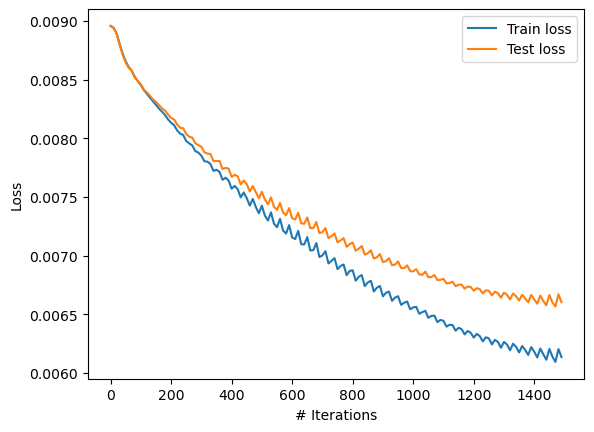

In [73]:
train_losses = list(map(lambda x: x.cpu(), train_losses))
test_losses = list(map(lambda x: x.cpu(), test_losses))

plt.plot(10*np.arange(0, len(train_losses)), train_losses, label='Train loss')
plt.plot(10*np.arange(0, len(test_losses)), test_losses, label='Test loss')
plt.xlabel("# Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

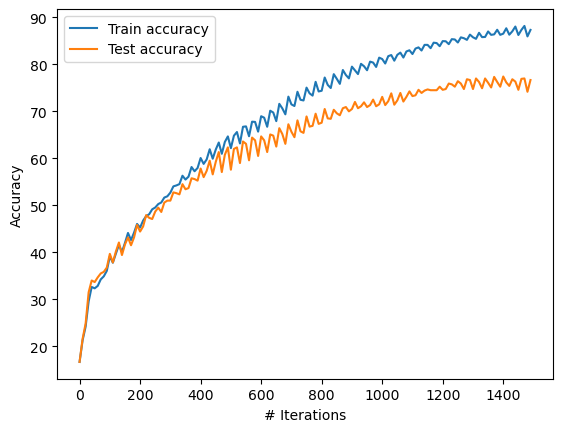

In [74]:
plt.plot(10*np.arange(0, len(train_accuracies)), train_accuracies, label='Train accuracy')
plt.plot(10*np.arange(0, len(test_accuracies)), test_accuracies, label='Test accuracy')
plt.xlabel("# Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show

### Model saving

We need to save the model using torchscript, in order to upload the model file to the competition server.
This may give errors for the following reason:

* In your model class, or layer classes, you use numpy functions or arrays, rather than tensors.

Thus make sure that you use torch tensors and functions inside these classes. Almost any numpy function
can also be performed using torch. Look at the torch documentation for further reference.

Saving the model to torchscript

In [11]:
# save model
torch.jit.save(torch.jit.script(model.to("cpu")), f"GlobalPoolVar_b{BATCH_SIZE}e{num_epochs}l{LEARNING_RATE}.pt")

### Loading the model from torchscript

This is what the competition server will be doing with your uploaded model.

In [7]:
model = torch.jit.load("b200e50l0.001.pt")

### Making a PCA plot of the output space

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Below we generate some random model outptus and targets, you must replace these with your own model's
output and the corresponding true targets.

In [31]:
test = test.to("cpu")
target_test = target_test.to("cpu")
model = model.to("cpu")

model_outputs = model(test)
targets = target_test

In [27]:
# generate outputs using trained model
outputs_PCA = PCA(n_components=2).fit_transform(model_outputs.detach().numpy())

# initialize scatterplot
fig, ax = plt.subplots()
scatter = ax.scatter(*outputs_PCA.T, c=targets, cmap='gist_rainbow', alpha=0.8)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
# set legend labels as languages
for i, text in enumerate(legend1.get_texts()):
    text.set_text(languages[i]);